# Plaquette energy vs beta

Replication of Gattringer and Lang page 99) 10 hits is IMPORTANT, so is number of su3 matrices 100+ give bigger values (wrong) for energy as well as no of correlation 

In [1]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

def generate_su2(epsilon):
    #generates a random su2 matrix where epsilon controls the "distance" from the identity
    r_random_numbers = np.random.uniform(0, 0.5, (4))
    r = np.empty((4))
    
    r[1:] = epsilon * r_random_numbers[1:] / np.linalg.norm(r_random_numbers[1:])
    r[0] = np.sign(r_random_numbers[0]) * np.sqrt(1-epsilon**2)
    
    r11 = r[0] + r[3]*1j
    r12 = r[1]*1j + r[2]
    r21 = r[1]*1j - r[2]
    r22 = r[0] - r[3]*1j
    
    return np.array([[r11, r12], [r21, r22]])
    
def generate_su3_array(n, epsilon):
    #generates a 2*n array of su3 matrices where epsilon controls the distance from the idenity
    su3_array = np.empty((2*n, 3, 3), dtype = 'complex128')
    
    for i in range(n):

        R_su3 = np.identity(3, dtype=complex)
        S_su3 = np.identity(3, dtype=complex)
        T_su3 = np.identity(3, dtype=complex)

        R_su3[:2, :2] = generate_su2(epsilon)
        S_su3[0:3:2, 0:3:2] = generate_su2(epsilon)
        T_su3[1:, 1:] = generate_su2(epsilon)
        
        X_su3 = np.dot(np.dot(R_su3, S_su3), T_su3)

        su3_array[2*i, :, :] = X_su3
        su3_array[2*i+1, :, :] = X_su3.conj().T
        
    return su3_array

### Classes for the lattice and the site at each lattice point.

Site value is just a scalar here as this is a simple gauge simulation. The fundamental data structure of the lattice is a numpy array of site objects which have four links initialised to the identity matrix.

In [2]:
def generate_site():
    #Returns a 4 dimensional array of su3 matrices initialised to the identity which can be assigned to each
    #spatial lattice point
    link_value = np.identity(3, dtype = 'complex128')
    link = np.tile(link_value, (4, 1, 1))
    
    return link
        

def generate_lattice(n_points):
    #Returns a (n_points, n_points, n_points, n_points, 4, 3, 3) numpy array as our lattice with 4
    #su3 links assigned to each grid point
    volume = np.append(np.repeat(n_points, 4), (4,3,3))
    grid = np.empty(volume, dtype = 'complex128')
    
    for t in range(n_points):
        for x in range(n_points):
            for y in range(n_points):
                for z in range(n_points):
                    grid[t, x, y, z, :, :, :] = generate_site()
                        
    return grid

def link(lattice, coordinates, mu):
    #Function to take into account periodic bd conditions
    n_points = lattice.shape[0]
        
    return lattice[coordinates[0] % n_points, coordinates[1] % n_points, 
                   coordinates[2] % n_points, coordinates[3] % n_points, mu, : , :]

In [3]:
def wilson_link_sum(lattice, coordinates,  mu, u_0):
    #Staple sum for the wilson plaquette action
    dimension = 4
    res = np.zeros((3,3), dtype = 'complex128')
    
    for nu in range(dimension):
        if nu != mu:
            
            coordinates_mu = coordinates[:]
            coordinates_mu[mu] += 1
            
            coordinates_nu = coordinates[:]
            coordinates_nu[nu] += 1
            
            coordinates_mu_n_nu = coordinates[:]
            coordinates_mu_n_nu[mu] += 1
            coordinates_mu_n_nu[nu] -= 1
            
            coordinates_n_nu = coordinates[:]
            coordinates_n_nu[nu] -= 1
            
            #1x1 positive
            res += np.dot(np.dot(link(lattice, coordinates_mu, nu), 
                                 link(lattice, coordinates_nu, mu).conj().T),
                                 link(lattice, coordinates,    nu).conj().T)
            #1x1 negative
            res += np.dot(np.dot(link(lattice, coordinates_mu_n_nu, nu).conj().T, 
                                 link(lattice, coordinates_n_nu,    mu).conj().T), 
                                 link(lattice, coordinates_n_nu,    nu))
        
    return res / u_0**4 / 3

In [4]:
def update_link(lattice, coordinates, mu, link_sum, su3_set, su3_set_length, beta, u_0, n_hits):
    
    accept = 0
    
    t = coordinates[0]
    x = coordinates[1]
    y = coordinates[2]
    z = coordinates[3]
    
    #compute staple once for given link
    staple = link_sum(lattice, coordinates,  mu, u_0)
    
    #update single link multiple times to bring into equilibrium with surrounding links
    for i in range(n_hits):

        su3_matrix = su3_set[np.random.randint(0, su3_set_length)]
        
        new_link = np.dot(su3_matrix , lattice[t, x, y, z, mu, : , :])
        
        diff = new_link - lattice[t, x, y, z, mu, : , :]
    
        deltaS = beta * np.trace(np.dot(diff, staple)).real
    
        if np.exp(deltaS) > np.random.rand():
          
            lattice[t, x, y, z, mu, : , :] = new_link
            accept += 1
    
    return accept / n_hits

In [5]:
def update_lattice(lattice, link_sum, su3_set, beta, u_0, n_hits):
    n_points = lattice.shape[0]
    dimension = 4 
    acceptance = 0
    su3_set_length = len(su3_set)
    
    for t in range(n_points):
        for x in range(n_points):
            for y in range(n_points):
                for z in range(n_points):
                    for mu in range(dimension):
                        acceptance += update_link(lattice, [t,x,y,z], mu, link_sum, 
                                                  su3_set, su3_set_length, beta, u_0, n_hits)
                            
    return acceptance / dimension / n_points**dimension

In [6]:
def markov_chain(lattice, link_sum,  su3_set, beta, u_0, n_configs, n_corr, n_hits, 
                 thermal_steps = 100, thermalise = True):
    
    acceptance = 0
    ensemble = []
    
    #Thermalise
    if thermalise == True:
        for i in range(int(thermal_steps)):
            
            update_lattice(lattice, link_sum, su3_set, beta, u_0, n_hits=n_hits)
    
    #Equilibrium Update
    for j in range(n_configs*n_corr):
        
        acceptance += update_lattice(lattice, link_sum, su3_set, beta, u_0, n_hits=n_hits)
        
        if j % n_corr == 0:
            
            ensemble.append(lattice)
    
    if n_configs != 0 and n_corr != 0:
    
        acceptance = acceptance / n_configs / n_corr       
    
    return ensemble, acceptance

### Plaquette lattice average

In [7]:
def square_wilson_loop(lattice, coordinates, mu, nu):
    #compute upper plaquette
    coordinates_mu = coordinates[:]
    coordinates_mu[mu] +=1
    coordinates_nu = coordinates[:]
    coordinates_nu[nu] +=1
    
    res = np.dot(np.dot(np.dot(link(lattice, coordinates,    mu), 
                               link(lattice, coordinates_mu, nu)), 
                               link(lattice, coordinates_nu, mu).conj().T), 
                               link(lattice, coordinates,    nu).conj().T)
        
    return np.trace(res).real / 3


def square_lattice_average(lattice):
    #average plaquette over whole lattice
    dimension = 4
    unique_2d_loops_number = 6
    n_points = lattice.shape[0]
    
    res = 0
    for t in range(n_points):
        for x in range(n_points):
            for y in range(n_points):
                for z in range(n_points):
                    for mu in range(dimension):
                        for nu in range(mu):
                            res += square_wilson_loop(lattice, [t,x,y,z], mu, nu)
                                
    return res / n_points**dimension / unique_2d_loops_number

In [8]:
def gauge_average(lattice_ensemble, loop_average_function):

    loop_ensemble = list(map(loop_average_function, lattice_ensemble))
        
    return np.mean(loop_ensemble), np.std(loop_ensemble) / np.sqrt(len(lattice_ensemble))

In [9]:
su3_array = generate_su3_array(25, epsilon = 0.2)

In [10]:
def plaquette_energy_thermal(thermal_steps):
    
    latt = generate_lattice(n_points = 6)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = 5.5, u_0 = 1, n_configs = 10, n_corr = 50, n_hits = 10, 
                                         thermal_steps = thermal_steps)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop


def plaquette_plot_thermal():
    
    p = Pool(5)
    thermal_arr = np.linspace(10, 200, 20)
    energy_array = p.map(plaquette_energy_thermal, thermal_arr)
    p.terminate()
    
    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(thermal_arr, energy_array, 'g^')
    ax.set_title('Plaquette value vs thermalise steps')
    ax.set_xlabel("Thermalise Steps")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    return energy_array

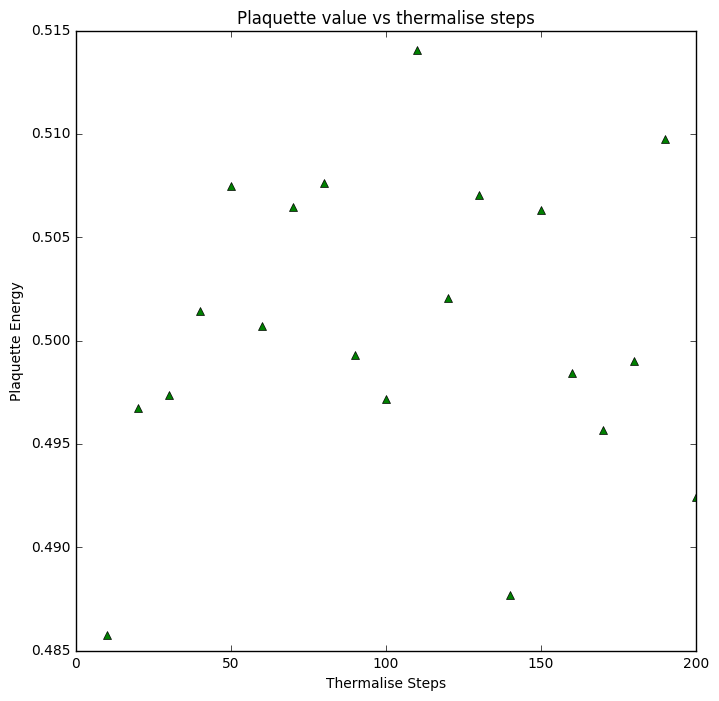

[0.48574945979262524,
 0.49673282578766093,
 0.49737830872431632,
 0.50144135485681596,
 0.50747005825682057,
 0.50070665125541081,
 0.50645455355242597,
 0.50761039513850392,
 0.49931753269016427,
 0.49717966125189034,
 0.51407983354128395,
 0.50204320385322831,
 0.50701991890939913,
 0.48770495950717613,
 0.50630921362002623,
 0.49844847152972294,
 0.49566398739443313,
 0.49899085945276339,
 0.50975599281177009,
 0.49244856415623256]

In [11]:
plaquette_plot_thermal()

In [12]:
def plaquette_energy_hits(hits):
    
    latt = generate_lattice(n_points = 6)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = 5.5, u_0 = 1, n_configs = 20, n_corr = 50, n_hits = hits)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop


def plaquette_plot_hits():
    p = Pool(5)
    

    hit_arr = range(1, 20)
    energy_array = p.map(plaquette_energy_hits, hit_arr)

    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(hit_arr, energy_array, 'g^')
    ax.set_title('Plaquette value vs hits')
    ax.set_xlabel("Hits")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    p.terminate()
    
    return energy_array

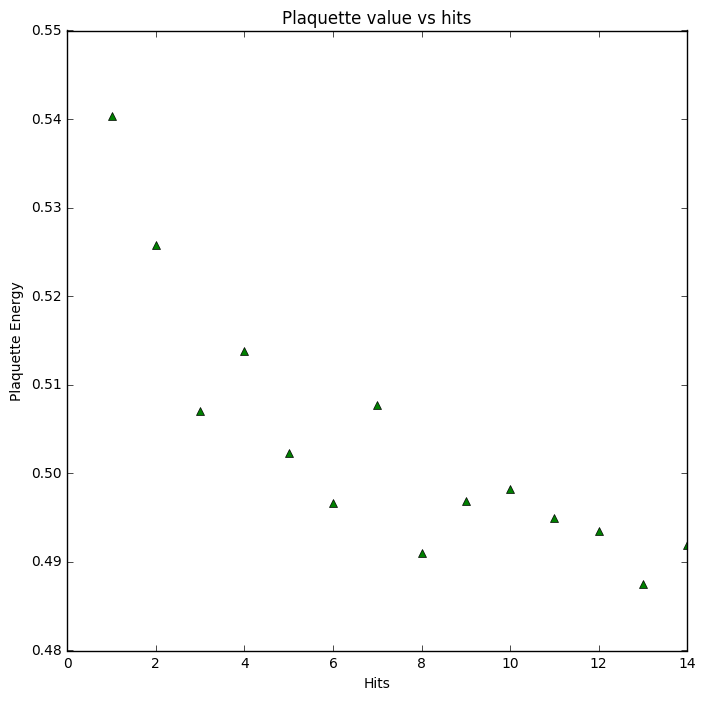

[0.54036658685180672,
 0.52574627380043504,
 0.50708843393129266,
 0.51382223137773109,
 0.50228490708089746,
 0.49661824514255271,
 0.50766384508703521,
 0.49100525261058225,
 0.49690452633933352,
 0.49818963398822069,
 0.49499806039826977,
 0.493523432302789,
 0.48746371454130905,
 0.49185560718986227]

In [13]:
plaquette_plot_hits()

In [14]:
def plaquette_energy_corr(corr):
    
    latt = generate_lattice(n_points = 6)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = 5.5, u_0 =1,  n_configs = 20, n_corr = corr, n_hits = 10)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop


def plaquette_plot_corr():
    p = Pool(5)
    

    beta_arr = range(1, 70, 5)
    energy_array = p.map(plaquette_energy_corr, beta_arr)

    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(beta_arr, energy_array, 'g^')
    ax.set_title('Plaquette value vs correlation number')
    ax.set_xlabel("Correlation number")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    p.terminate()
    
    return energy_array

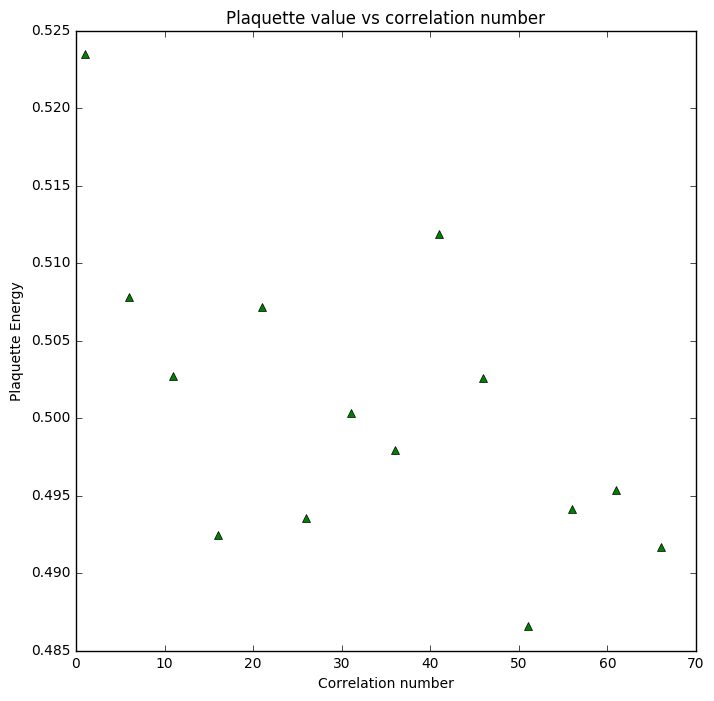

[0.52349062439671068,
 0.50778046137727229,
 0.50271101561150333,
 0.49246852726491835,
 0.50714328890397353,
 0.49351859347693106,
 0.50032717897200096,
 0.49796750732051126,
 0.51184464622148318,
 0.50257301424644285,
 0.48660666134973629,
 0.49411704929497208,
 0.49537025201187601,
 0.49170566740513227]

In [15]:
plaquette_plot_corr()

In [16]:
def plaquette_energy_beta(beta):
    
    latt = generate_lattice(n_points = 8)

    ensemble, acceptance1 = markov_chain(lattice = latt, link_sum = wilson_link_sum, su3_set = su3_array, 
                                         beta = beta, u_0=1, n_configs = 20, n_corr = 50, n_hits = 10)
    
    wilson_square_loop = gauge_average(ensemble, square_lattice_average)[0]
    
    del latt
    
    return wilson_square_loop

def plaquette_plot_beta():
    p = Pool(6)
    

    beta_arr = np.linspace(0, 8, 24)
    energy_array = p.map(plaquette_energy_beta, beta_arr)

    f, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.plot(beta_arr, energy_array)
    ax.set_title('Plaquette value vs beta')
    ax.set_xlabel("Beta")
    ax.set_ylabel("Plaquette Energy")
    plt.show()
    
    p.terminate()
    
    return energy_array

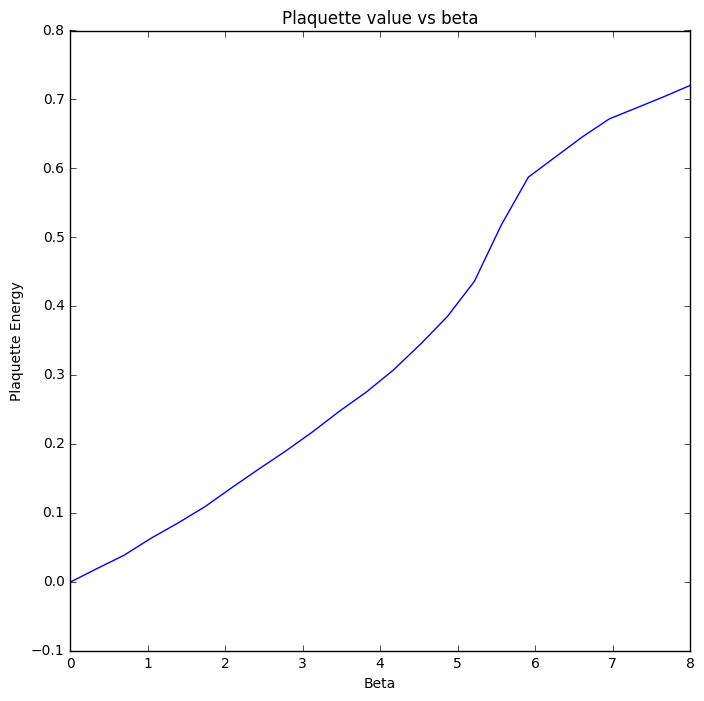

[-0.00086659077683441557,
 0.018977510403210156,
 0.038274645154770623,
 0.062910789834009995,
 0.085031328430026559,
 0.10870619206370739,
 0.13646657543752311,
 0.16340918320313591,
 0.18964176839237953,
 0.21757930707403741,
 0.24759662151048351,
 0.27551311059000771,
 0.30745863836419779,
 0.3447574574816864,
 0.38502031710750451,
 0.43608123155694045,
 0.51806847995791661,
 0.58716293891057503,
 0.61638525047738335,
 0.64549277713923781,
 0.67165552228092185,
 0.68750207915526507,
 0.70346239322086945,
 0.72028564645955417]

In [17]:
plaquette_plot_beta()